In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

To demonstrate mixed-effects models in the wild, we're going to use data from [a psychology study](https://osf.io/agfvc/) investigating the effects of meditating (vs. a waitlist control condition) on positive emotions over several weeks.  We will fit models with a random intercept, a random slope, and both, then try adding an additional predictor.  As we go, we'll focus on what we can learn about positive emotions, and whether meditating can change them.  Let's go!

In [17]:
# Loading the data in long format (each respondent has one row per response)
data=pd.read_csv('assets/2013_psych_science_winsorized.csv')
print(data.shape)
print(data.columns)

# Selecting the columns representing participant ID, experimental condition, and weekly positive-emotion reports.
positive_emotions = data[['ID','cond','P0','P1','P2','P3','P4','P5','P6','P7','P8']]
print(positive_emotions.head())

(73, 45)
Index(['ID', 'cond', 'female', 'hf_HRV_t1', 'hf_HRV_t2', 'RSA_t1', 'RSA_t2',
       'HRV_T1_SQRT_Z', 'HRV_T2_SQRT_Z', 'RSA_T1_Z', 'RSA_T2_Z', 'COND_HRV',
       'COND_RSA', 'RSA_Z', 'HRV_Z', 'USABLE', 'INTENT', 'P0', 'P1', 'P2',
       'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'N0', 'N1', 'N2', 'N3', 'N4', 'N5',
       'N6', 'N7', 'N8', 'S0', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8',
       'HRV_Z_WIN'],
      dtype='object')
       ID  cond        P0        P1        P2        P3        P4        P5  \
0  557001   1.0  2.222222  2.000000  1.888889  1.907407  1.888889  1.888889   
1  557002   1.0  4.444444  3.904762  4.148148  4.444444  4.079365  4.335979   
2  557003   1.0  1.911111  2.161111  2.200000  2.096296  2.166667  2.222222   
3  557004   1.0  1.622222  2.166667  2.055556  2.092593  1.472222  2.488889   
4  557005   0.0  2.380952  2.794444  2.533333  2.222222  2.444444  2.259259   

         P6        P7        P8  
0  1.888889  1.888889  1.822222  
1  4.259259  4.092

In [18]:
# Multilevel models expect data in a long format, with multiple rows per person.  Restructing data:
PE_long=pd.wide_to_long(positive_emotions, ['P',], i='cond', j='Week')
PE_long=PE_long.reset_index()
print(PE_long.head())

PE_long=PE_long.dropna()

   cond  Week      ID         P
0   1.0     0  557001  2.222222
1   1.0     0  557002  4.444444
2   1.0     0  557003  1.911111
3   1.0     0  557004  1.622222
4   0.0     0  557005  2.380952


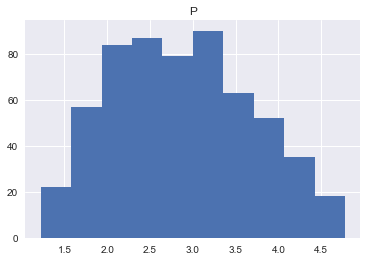

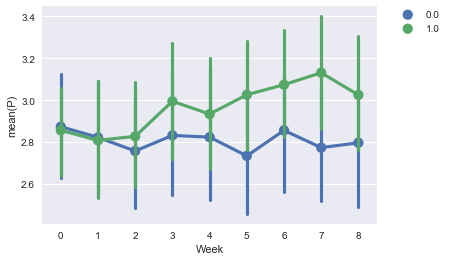

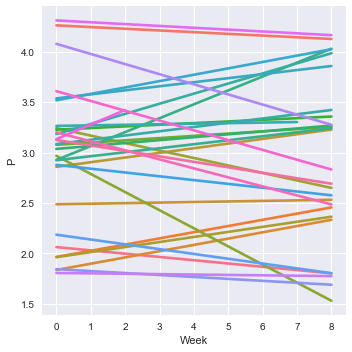

In [19]:
# Getting a sense for the data

# Checking the distributions: Is the outcome normally distributed, or close to it?
PE_long[['P']].hist()
plt.show()

# Looking for overall patterns
sns.axes_style("white")
sns.pointplot(x="Week"
            ,y="P"
            ,hue='cond'
            ,data=PE_long)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Looking at trajectories of change for the first 30 respondents
sns.axes_style("white")
sns.lmplot(x="Week"
           , y="P"
           , hue='ID'
           , data=PE_long.loc[PE_long['ID']<557030,:]
           , ci=None
           , scatter_kws={'alpha':0.3}
           , legend=None
           , markers=""
           , truncate=True
          )
plt.show()

# Assumptions

Linear mixed-effect models make the following assumptions:

* The features are related linearly to the outcome.
* The errors have constant variance: In other words, the model fits equally well for all values of the outcome and features within a level.
* The errors are independent: The fit of the model at one level (such as level 1) is uncorrelated with the fit of the model at another level (such as level 2).
* The errors are normally distributed.
* Observations within a person/group are correlated with one another: this is also known as dependency.

## Checking Assumptions

A normally distributed outcome variable is more likely to generate normally-distributed errors, thus the interest in the distribution of the outcome (which we checked above).  In our case, the positive emotions variable is sufficiently normal for this method.

It is possible that positive emotions don't change steadily over time, but were steady and then dropped or increased sharply due to some event.  In that case, the linear approach would not fit well.  The best check for non-linearity is to graph the data before modeling.  The graph above looks like there may be an overall increase in positive emotions in the experimental group only.

To check for dependency, we look at the ratio of the variance between persons (how much people differ from each other) to the total variance in a model with no fixed effects and only a random intercept.  This is called the *IntraClass Correlation* (ICC) because the number represents the average correlation between observations within a person/group.  If this value is close to zero, there is no dependency and thus no need to use a mixed-effects model.

When choosing between models, we can check whether the model fits equally well for all values of the outcome and features by plotting the residuals (the discrepancy between the model prediction and the true value) by the outcome and feature variables and looking for patterns.  To do this, we'll first need a model.

## Calculating ICC


In [20]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLMParams

# Model to use for calculating the ICC
print('running...')
model = smf.mixedlm("P ~ 1",data=PE_long,groups=PE_long['ID'])
result = model.fit(method='nm',maxiter=200, full_output=True)
print(result.summary())
print("done!")

# Function to calculate the intraclass correlation
def ICC(fittedmodel):
    between_var= fittedmodel.cov_re.iloc[0,0]
    resid=fittedmodel.scale
    icc=between_var/(between_var+resid)
    return icc

print('The Intraclass Correlation is: {}'.format(ICC(result)))


running...
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: P        
No. Observations: 587     Method:             REML     
No. Groups:       67      Scale:              0.1344   
Min. group size:  3       Likelihood:         -363.3242
Max. group size:  9       Converged:          Yes      
Mean group size:  8.8                                  
-------------------------------------------------------
              Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     2.886    0.089 32.353 0.000  2.711  3.061
groups RE     0.517    0.268                           

done!
The Intraclass Correlation is: 0.7937601562687884


It appears that we have a reason to use a mixed model: Observations within a person correlate 79.4%!  

Now we'll try models various models and see how they perform:

In [21]:

print('running random intercept model')
ri_model = smf.mixedlm("P ~ Week",data=PE_long,groups=PE_long['ID'])
ri_result = ri_model.fit(method='nm',maxiter=200, full_output=True)
print(ri_result.summary())
print("done!")


running random intercept model
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: P        
No. Observations: 587     Method:             REML     
No. Groups:       67      Scale:              0.1331   
Min. group size:  3       Likelihood:         -364.5960
Max. group size:  9       Converged:          Yes      
Mean group size:  8.8                                  
-------------------------------------------------------
              Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     2.830    0.092 30.717 0.000  2.650  3.011
Week          0.014    0.006  2.432 0.015  0.003  0.026
groups RE     0.518    0.270                           

done!


## Interpreting the output

Before we go on to the random slopes and random slopes+random intercepts models, let's talk through all the output we just got.  There's a lot of it!  This is a feature of interpretive, rather than predictive, modeling-- rather than one accuracy score, we are interested in a lot of different numbers.

At the top left is information describing the data- the number of observations, number of groups, etc.
The top right has information about the model overall.  It includes the maximum likelihood method used (REML, or Restricted Maximum Likelihood- it is less prone to biased estimates than regular ML), the residual (unexplained) variance, the likelihood score, and whether the model converged.  

### Residual
The residual (error) variance is not a very interesting number in itself, as it isn't scaled and so can't be directly compared across models.  Statsmodels calls it 'scale' because all the other numbers are scaled to it.  It is used in computing the ICC.

### Likelihood
The likelihood score is also not of much interest on its own.  However, it is useful for comparing nested models.  Two models are considered 'nested' if the parameters of one model are a subset of the parameters of another.  For example, a model with a random intercept is a subset of a model with a random intercept and slope.  On the other hand, that same random intercept model is *not* a subset of a random slope model.  When two models are nested, the model with a lower likelihood score is a better fit.  It is the convention to compare the natural logs of the likelihoods rather than the raw likelihood score, so you will often hear this referred to as the 'log likelihood'.

### Convergence
If a model hasn't converged, that means the solution is not stable or optimal and should not be trusted.  There are [a lot of optimization algorithms](https://github.com/statsmodels/statsmodels/issues/1641)- if one doesn't converge, try another.  Models may not converge if they are a very poor fit to the data or if many variance parameters are close to or equal to zero.

## Computing the random slope and random slope/intercept models, and deciding which is best

In [22]:

print('running random slopes model')
rs_model = smf.mixedlm("P ~ Week",data=PE_long,groups=PE_long['ID'], re_formula="~0+Week")
rs_result = rs_model.fit(method='nm',maxiter=200, full_output=True)
print(rs_result.summary())
print("done!")

print('running random intercept and random slopes model')
ris_model = smf.mixedlm("P ~ Week",data=PE_long,groups=PE_long['ID'], re_formula="~Week")
ris_result = ris_model.fit(method='nm', maxiter=200, full_output=True)
print(ris_result.summary())
print("done!")

running random slopes model
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: P        
No. Observations: 587     Method:             REML     
No. Groups:       67      Scale:              0.2778   
Min. group size:  3       Likelihood:         -545.6852
Max. group size:  9       Converged:          Yes      
Mean group size:  8.8                                  
-------------------------------------------------------
              Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     2.825    0.040 70.689 0.000  2.746  2.903
Week          0.015    0.018  0.835 0.404 -0.020  0.051
Week RE       0.017    0.006                           

done!
running random intercept and random slopes model
              Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    P        
No. Observations:     587        Method:                REML     
No. Groups:  

C:\Users\Bethany\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


## Comparing fit using log-likelihood scores

The *likelihood ratio test* of comparative model fit for nested models requires two numbers: First, the natural log of the difference of the two log likelihoods multiplied by 2, and second, the difference in *degrees of freedom*.

The log-likelihood difference is easy: $2(likelihood1-likelihood2)$

For the second, degrees of freedom refers to the number of parameters being estimated relative to the total sample size.  The 'parameters being estimated' are any values that are estimated by the model- any fixed effects, any random effects, and any correlations among effects.  For example, in the random intercept model there are 3 parameters: The fixed intercept, the random intercept, and the fixed slope.  The random intercept/slope model has 5 parameters: The fixed intercept and slope, the random intercept and slope, and the correlation between the random slope and random intercept.

Since the total sample size is the same across nested models (otherwise they aren't nested), the difference in degrees of freedom between models is simply the difference in number of parameters.

In [25]:
from scipy.stats import chi2

def likelihood_ratio_test(bigmodel, smallmodel):
    likelihoodratio=2*(bigmodel.llf-smallmodel.llf)
    df=bigmodel.df_modelwc-smallmodel.df_modelwc
    p=chi2.sf(likelihoodratio, df)
    return p


lrt=likelihood_ratio_test(ris_result,ri_result)
print('The p-value for the likelihood ratio test of the random intercept and random intercept/slope models is: {}'.format(lrt))

The p-value for the likelihood ratio test of the random intercept and random intercept/slope models is: 7.539432049282251e-08


## Which is better?

It appears that the the random intercept/slope models explains significantly more variance than the random intercept slope model (the p-value was tiny!).  If they had not been significantly different, the convention is to take the more parsimonious model (the one with fewer parameters).

## Drill

We haven't run any fit tests using the random slopes model.  Compare that model with the others- which should we use? How do you know?  Show your math and logic to your mentor.

In [1]:
# Drill answers


# Residuals

Now that we have a structure we think is acceptable, let's check whether our residuals are congruent with the model assumptions:

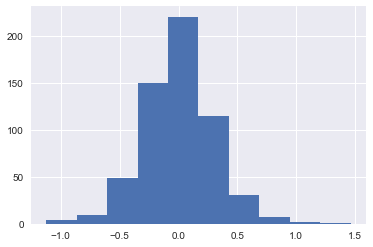

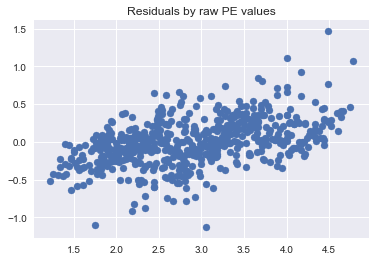

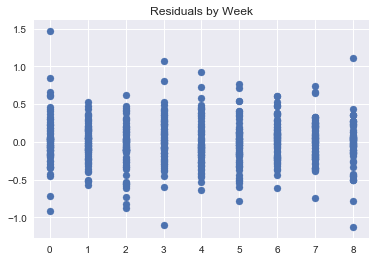

In [33]:
PE_long['residual']=ris_result.resid

# Are residuals normally distributed?
plt.hist(PE_long['residual'])
plt.show()

# Is variance constant for all values of the outcome?
plt.scatter(PE_long['P'],PE_long['residual'])
plt.title('Residuals by raw PE values')
plt.show()

# Is variance constant for all values of the predictors?
plt.scatter(PE_long['Week'],PE_long['residual'])
plt.title('Residuals by Week')
plt.show()

It looks like our residuals are nicely normal, but there are some worrying patterns when the residuals are plotted against the raw positive emotion values or the week values.  In both cases, we are looking for a plot with no patterns- if we fitted a line, it should be horizontal.  In the first plot, it looks like the model has some trouble predicting the lowest and highest PE scores.  In the second, there is a suggestion of non-linearity.  We are going to leave things alone for now, but both residual plots hint that other features (a non-linear week parameter, perhaps) might be desirable.

## Interpretation

Alright, having chosen our random effects structure and settled on a fixed effects structure, we can now look at the fixed effect parameters and see what we can learn about how peoples' positive emotions changed over the 9 weeks of the study.  Let's re-print the output here:

In [26]:
print(ris_result.summary())

              Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    P        
No. Observations:     587        Method:                REML     
No. Groups:           67         Scale:                 0.1118   
Min. group size:      3          Likelihood:            -348.1954
Max. group size:      9          Converged:             Yes      
Mean group size:      8.8                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               2.830    0.090 31.388 0.000  2.654  3.007
Week                    0.014    0.009  1.675 0.094 -0.002  0.031
Intercept RE            0.502    0.304                           
Intercept RE x Week RE -0.003    0.019                           
Week RE                 0.003    0.003                           



It appears that, on average, people started the study with a positive emotion score of 2.83 (lowest possible score 1, highest possible score 5.  We know this because that is the value for the Intercept, where Week == 0.  Each week, on average, peoples' positive emotions rose by .014.  However, the p-value for the week slope is 0.094, which tells us that this seeming positive trend may be due to chance-- and the high standard error (.009).  So we would conclude that, on average, there was no statistically significant linear change in positive emotions when looking over the entire sample.

Another interesting set of parameters to examine are the random effects. They don't have significance tests, but we know that the model fits better with all of these included than if one is excluded.  This suggests that there is significant variation across people in their mood when they started the study and their rate of change in mood over the course of the study.

# Drill: Does Meditation Matter?

You may notice that our analysis so far doesn't actually address the central question of the study- whether people in the meditation condition would increase in positive emotions while people in the control condition did not change.  Your task is to test this hypothesis by including the 'cond' (condition) variable in the model.  The experimental condition is cond == 1, and the control condition is cond == 0.  

The hypothesis actually has two pieces to it.  First, it assumes that both groups' moods were similar at the start of the study, since people were randomly assigned to groups.  And second, it assumes that the slope for the experimental group will be significantly steeper than the slope for the control group.

To help you out, here are the equations for the model to test:

Level one:

$$P_{ti} = \beta_{0i} + \beta_{1i}Week_{ti}+e_{ti}$$

Level two:

$$\beta_{0i}=\gamma_{00} + \gamma_{01}Cond_i + \mu_{1i}$$
$$\beta_{1i}=\gamma_{10} + \gamma_{11}Cond_i + \mu_{1i}$$

Hint: Most software packages for mixed effects models don't use the level 1/level 2 notation in their syntax.  To go from these equations to something easier to feed to ´statsmodels´, combine the equation sets by substituting the level 2 equations for $\beta_{0i}$ and $\beta_{1i}$ into the level 1 equation.  If you've done it right, your final combined equation should have no $\beta$ coefficients left, only $\gamma$s and $\mu$s.

Did the experimental manipulation work?  Support your argument with statistics, including interpreting the coefficients and p-values.  Write up a report and share it with your mentor.